In [1]:
import fiftyone as fo
import numpy as np

dataset = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="train",
              label_types=["detections"],
              classes=["Cat"],
            #   max_samples=10,
          )

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v7-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import cv2

In [3]:
# try fewer samples
# n_samples = len(dataset)
n_samples = 100


x_size = 267
y_size = 326

In [4]:
# batching is not necessary if we're using fasterrcnn_resnet50_fpn.

batch_size = 70
# (267 x 326) is the number of pixels in the smallest images
# TODO: we downsize all images? i guess
batched_data = torch.zeros([n_samples// batch_size, batch_size, 3, y_size, x_size], dtype=torch.float32)
# batched_boxes = np.ndarray((n_samples // batch_size, batch_size, 4))
batched_targets = []

for batch_index in range(n_samples // batch_size):
    for i, sample in enumerate(dataset[batch_index * batch_size:(batch_index + 1) * batch_size]):
        batched_data[batch_index, i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))
        batched_targets.append([])
        for detection in sample['ground_truth']['detections']:
                box = detection['bounding_box']

                x_min, y_min, width, height = box
                x_max = x_min + width
                y_max = y_min + height
                target = {
                    'boxes': torch.tensor([[x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size]], dtype=torch.float32),
                    'labels': torch.tensor([1 if detection['label'] == 'Cat' else 0], dtype=torch.int64),  # Assuming 1 is the label for 'Cat'
                }
                batched_targets[batch_index].append(target)


In [5]:
unbatched_data = torch.zeros([n_samples, 3, y_size, x_size], dtype=torch.float32)
# unbatched_boxes = np.ndarray((n_samples, 4))
targets = []
for i, sample in enumerate(dataset[:n_samples]):
    unbatched_data[i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))
    for detection in sample['ground_truth']['detections']:
            box = detection['bounding_box']

            x_min, y_min, width, height = box
            x_max = x_min + width
            y_max = y_min + height
            target = {
                'boxes': torch.tensor([[x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size]], dtype=torch.float32),
                'labels': torch.tensor([1 if detection['label'] == 'Cat' else 0], dtype=torch.int64),  # Assuming 1 is the label for 'Cat'
            }
            targets.append(target)

In [6]:
# def loss_fn(predictions, targets):
#     sum_losses = 0
#     for i in range(len(predictions)):
#         p_boxes = predictions[i]['boxes']
#         p_labels = predictions[i]['labels']
#         t_boxes = targets[i]['boxes']
#         t_labels = targets[i]['labels']

#         image_sum_losses = 0
#         n_boxes = min(len(p_boxes), len(t_boxes))
        
#         for i in range(n_boxes):
            


#     return sum_losses / len(predictions)

In [7]:
# using documentation from https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn
from sklearn.metrics import average_precision_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes = 2)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# model.eval()
# for i in range(min(10, n_samples // batch_size)):
for i in [0]:
    # optimizer.zero_grad()
    print(f"iteration {i}:\t\t",end="")
    output = model(batched_data[i], batched_targets[i])
    # output['loss_box_reg'].backward()
    # output['loss_classifier'].backward()
    # optimizer.step()
    # print(output)
    model.eval()
    print(f"loss_classifier: {output['loss_classifier'].item()},\t\t loss_box_reg: {output['loss_box_reg'].item()}")
    model.train()

iteration 0:		loss_classifier: 1.477945327758789,		 loss_box_reg: 0.881747841835022


In [8]:
model.eval()
print(output)

{'loss_classifier': tensor(1.4779, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.8817, grad_fn=<DivBackward0>), 'loss_objectness': tensor(8.4951, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(1.6390, grad_fn=<DivBackward0>)}


In [9]:
import fiftyone as fo
import numpy as np

test_set = fo.zoo.load_zoo_dataset(
              "open-images-v7",
              split="test",
              label_types=["detections"],
              classes=["Cat"],
            #   max_samples=10,
          )

test_samples = 10

test_data = torch.zeros([test_samples, 3, y_size, x_size], dtype=torch.float32)
test_targets = []
for i, sample in enumerate(dataset[:test_samples]):
    test_data[i] = torch.from_numpy(cv2.resize(cv2.imread(sample['filepath']), (x_size, y_size)).transpose(2, 0, 1))

    boxes = []
    labels = []
    for detection in sample['ground_truth']['detections']:
        box = detection['bounding_box']

        x_min, y_min, width, height = box
        x_max = x_min + width
        y_max = y_min + height
        boxes.append([x_min * x_size, y_min * y_size, x_max * x_size, y_max * y_size])
        labels.append(1 if detection['label'] == 'Cat' else 0)  # Assuming 1 is the label for 'Cat'
    target = {
        'boxes': torch.tensor(boxes, dtype=torch.float32),
        'labels': torch.tensor(labels, dtype=torch.int64),
    }
    test_targets.append(target)

Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading existing dataset 'open-images-v7-test'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [10]:
predictions = model(test_data)
print(predictions)

[{'boxes': tensor([[  0.0000, 127.1477, 267.0000, 130.7466],
        [  0.0000, 322.4889, 267.0000, 322.5500],
        [  0.0000, 102.3737, 267.0000, 102.6959],
        [  0.0000,  48.2598, 267.0000,  48.2635]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1]), 'scores': tensor([1.0000, 0.9981, 0.6603, 0.2840], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[161.3957, 107.1177, 238.8686, 326.0000],
        [  0.0000,   0.0000, 267.0000, 326.0000],
        [ 90.1321,   0.0000, 105.1126, 326.0000],
        [253.4909,   0.0000, 267.0000, 326.0000],
        [265.9314,   0.0000, 266.2471, 326.0000],
        [  0.0000, 203.8695, 255.9146, 228.9514],
        [215.5873,   0.0000, 215.7350, 326.0000],
        [219.8756,   0.0000, 220.0793, 326.0000],
        [203.7681,   0.0000, 206.8619, 326.0000]], grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9870, 0.5145, 0.0531],
       grad_fn=<IndexBac

In [11]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import average_precision_score


# acc_score = accuracy_score(test_targets, predictions)
# print(f"Accuracy Score: {acc_score}")
# avg_prec_score = average_precision_score(test_targets, predictions)
# print(f"Average Precision Score: {avg_prec_score}")

0 4
1 9
2 2
3 8
4 3
5 3
6 3
7 2
8 4


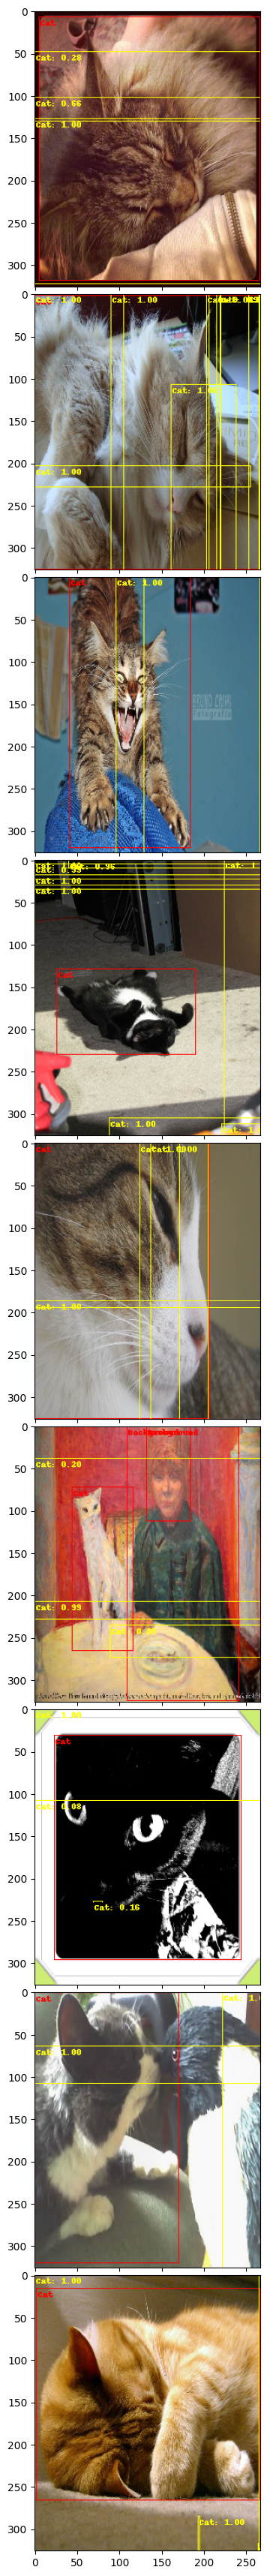

In [12]:
# from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import draw_bounding_boxes
from mpl_toolkits.axes_grid1 import ImageGrid

num_plots = 9
fig = plt.figure(figsize=(num_plots, 4.*num_plots*y_size/x_size))
grid = ImageGrid(fig, 111, nrows_ncols=(num_plots, 1), axes_pad=0.1)
for i in range(num_plots):
    # grid[i].imshow(data[i])

    image_index = i
    # print(test_data[image_index], test_targets[image_index])

    label_strings = []
    for label in test_targets[image_index]['labels']:
        label_strings.append("Cat" if label == 1 else "Background")

    prediction_label_strings = []
    for j, label in enumerate(predictions[image_index]['labels']):
        prediction_label_strings.append(f"Cat: {predictions[image_index]['scores'][j]:0.2f}" if label == 1 else "Background")
    print(i,len(prediction_label_strings))


    output_image = draw_bounding_boxes(test_data[image_index].to(torch.uint8).flip(0), test_targets[image_index]['boxes'], label_strings, colors="red")
    output_image = draw_bounding_boxes(output_image, predictions[image_index]['boxes'], prediction_label_strings, colors="yellow")
    grid[i].imshow(output_image.permute(1, 2, 0))

In [ ]:
import datetime
print(datetime.datetime.now())
torch.save(model.state_dict(), f"./model_{batch_size}_{datetime.datetime.now()}")

2024-12-12 18:31:10.565052
